### Figure
#### K-Means error as a function of variance above dimension n

In [2]:
cd /Users/cl1704/PycharmProjects/embedding_dimension/BWM

/Users/cl1704/PycharmProjects/embedding_dimension/BWM


In [3]:
import numpy as np
import pandas as pd
#from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
#from kneed import KneeLocator
from sklearn.manifold import Isomap
from matplotlib import gridspec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.stats import special_ortho_group

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from datajoint_tables import *
import datajoint as dj_langdon
dj_langdon.config['database.host'] = 'datajoint-tengel.pni.princeton.edu'
dj_langdon.config['database.user'] = 'cl1704'
dj_langdon.config['database.password'] = 'wuxty2-mYdxej-kerxaq'
schema = dj_langdon.schema('langdon_ibl_manifold')
schema.spawn_missing_classes()

from sklearn.metrics import silhouette_score
import os
import scipy.optimize as opt
plt.rcParams["axes.grid"] = False
import matplotlib
matplotlib.rcParams['axes.linewidth'] = .75

[2025-05-02 14:36:38,578][INFO]: Connecting cl1704@datajoint-tengel.pni.princeton.edu:3306
[2025-05-02 14:36:39,370][INFO]: Connected cl1704@datajoint-tengel.pni.princeton.edu:3306


In [68]:
original_df = pd.DataFrame((Experiment_1() ).proj('eid','beryl','cosmos','n_neurons','variance','inertia','n_trials','null_param','activity_std','k','responses','p','null_inertia').fetch())
original_df = original_df[original_df.n_neurons>=50]
original_df = original_df[original_df.activity_std<7]

SSp-n
SSp-n
SSp-n
SSp-n


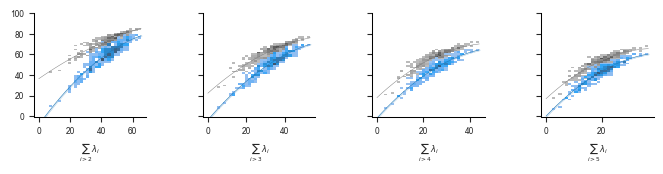

In [75]:
fig = plt.figure(figsize=(8,1.35))
gs = gridspec.GridSpec(1,4,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]


for i in range(4):
    ax = axes[i]
    df = original_df.copy()
    k = i+2
    #df = df[df.k>=k]

    #df['var'] = df.responses.apply(lambda x: compute_var(x,k)) 
    df['var'] = df.variance.apply(lambda x: 100*x[k-1]) 
    df['var_prev'] = df.variance.apply(lambda x: 100*x[k-2]) 
    df['k_inertia'] = df.inertia.apply(lambda x: 100*x[k-1])
    df['z'] = (df.var_prev - df.var_prev.mean()) / np.std(df.var_prev)
    q = df.var_prev.quantile(0.01)
    df = df.sort_values('var_prev')
    #df = df.iloc[2*k+2:,:]
    print(df.beryl.values[0])
    #df = df[df.var_prev>20]
    #df['var']  = np.log(df['var'] )
    #df = df[df.activity_std<5]
    # df['p'] = df.apply(lambda x : compute_p(x['k'],x['inertia'],x['null_inertia']),axis=1)
    
    
    #df = df[df['var']>-3]
    #Get inertia for rotated data and k clusters
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'eid':row['eid'],
            'beryl': row['beryl'],
                         'var':row['var'],
            'run':run,
            'inertia': 100*null[k-1,run]})
    null_df = pd.DataFrame(rows)       

    null_df = null_df.groupby(['eid','beryl']).mean().reset_index()
   
    def f(x, a,b,c,d,e):
        #return a + c*np.log(1+np.exp(b * (x-d)))/b
       # return a + c*np.log(1+np.exp(20 * (-x-b)))/20
        #return  a + b/(1+np.exp(c*(x-d)))
        return a+b*x+c*x**2
        #return a + b*np.log(c*(x-d))
        #return b*np.log(x-a)
    
    fit_rows = []
    med = df['var'].quantile(1)
    max = df['var'].quantile(1)
    for sample in range(100):   
        #try:
        frac = 1
        
        x_values = np.linspace(0,med,20)
        sample_df = df[df['var']<=med].sample(frac=frac)
        x = sample_df['var'].values.astype(float)
        y = sample_df.k_inertia.values

        sample_null_df = null_df[null_df['var']<=med].sample(frac=frac)
        x_null = sample_null_df['var'].values.astype(float)
        y_null = sample_null_df.inertia.values

        # bounds = ([0,0,0,-np.inf],
        #           [1, np.inf,np.inf,0])
        bounds = ([-np.inf,-np.inf,-np.inf],
                  [np.inf,np.inf,np.inf])
        try:
            popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
            y_fit = f(x_values, *popt)

            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step': step,
                                 'k':k,
                             'type': 1,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a': f(df['var'].min(),*popt)})
        except:
            continue

        try:
            #popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000)
            popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000)
            y_fit = f(x_values, *popt)
            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step':step,
                                 'k':k,
                             'type': 0,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':f(df['var'].min(),*popt)})
        except:
           continue

    fit_df = pd.DataFrame(fit_rows)
    # for k in range(4):
    #     ax = axes[k]
    sns.lineplot(data = fit_df[(fit_df.type==1) ], x= 'x', y='y',ax=ax,legend = False,lw=.35,color='tab:blue',alpha = 1,errorbar='sd')
    sns.lineplot(data = fit_df[(fit_df.type==0)], x= 'x', y='y',ax=ax,legend = False,lw=.35,color='gray',alpha= 1, errorbar = None)

    
    sns.histplot(data=null_df, x='var',y='inertia',ax=ax,legend=False,color='gray',alpha=1,bins=(30,30))
    #sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=.75,bins=(35,35),color='gray')
    sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=1,bins=(30,30))
    #sns.regplot(data=df, x="var", y="k_inertia", lowess=True,ax=ax,scatter_kws={'s':3,'alpha':.5})
    #sns.histplot(data=df[df.cosmos=='TH'], x='var',y='k_inertia',ax=ax,legend=False,alpha=.75,color='red')


    
for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=True)
    ax.yaxis.set_tick_params(labelsize=6,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
    ax.set_ylim(-1,100)
    #ax.set_xlim(-1,100)
   
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel( r"$\sum_{i>2}\lambda_i$", fontsize=6)
ax1.set_xlabel(r"$\sum_{i>3}\lambda_i$", fontsize=6)
ax2.set_xlabel(r"$\sum_{i>4}\lambda_i$", fontsize=6)
ax3.set_xlabel(r"$\sum_{i>5}\lambda_i$", fontsize=6)
fig.savefig('/Users/cl1704/PycharmProjects/Clustering/Figures/MainFig_1_a.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
            )

<Axes: xlabel='a', ylabel='Count'>

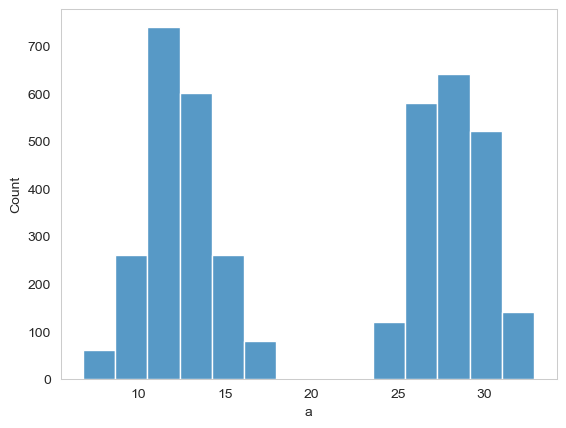

In [49]:
plt.figure()
sns.histplot(data = fit_df, x = 'a')

In [13]:
df.sort_values('var')

,beryl,cosmos,eid,n_time,n_active,sigma,trial_length,n_splits,null_param,variance,...,null_inertia,k,activity_std,n_neurons,responses,n_trials,var,var_prev,k_inertia,z
634,SSp-n,Isocortex,35ed605c-1a1a-47b1-86ff-2b56144f55af,10,100,2.0,0.50,25,1.0,"[0.11757835522782162, 0.06662523166376577, 0.0...",...,"[[0.996956710392738, 0.9960237152192334, 0.996...",1,0.444148,90,"[[-0.9942171951408938, -0.9942171951408938, -0...",522,2.129602,3.134416,6.169673,-3.343942
645,SSp-ul,Isocortex,e56541a5-a6d5-4750-b1fe-f6b5257bfe7c,10,100,2.0,0.50,25,1.0,"[0.17559382323820297, 0.12659288855678705, 0.0...",...,"[[0.991080092702839, 0.9895028090793769, 0.967...",1,0.788856,50,"[[-0.6555839919802758, -0.5593456614939574, -0...",583,4.861489,6.428758,9.814170,-2.814777
14,ANcr1,CB,a9138924-4395-4981-83d1-530f6ff7c8fc,10,100,2.0,0.50,25,1.0,"[0.19570175214251329, 0.13119946275705271, 0.0...",...,"[[0.985197297221326, 0.994010441669226, 0.9788...",1,7.311750,67,"[[-0.622399451209695, -0.622399451209695, -0.6...",884,4.910938,6.800251,10.452866,-2.755105
693,VISp,Isocortex,07dc4b76-5b93-4a03-82a0-b3d9cc73f412,10,100,2.0,0.50,25,1.0,"[0.3713338868407103, 0.1850088906662997, 0.118...",...,"[[0.95751637625293, 0.9963771701630877, 0.9959...",2,3.577370,68,"[[-0.7399260946472193, -0.7399260946472193, -0...",692,6.321929,8.747186,16.932239,-2.442371
674,VCO,HB,71855308-7e54-41d7-a7a4-b042e78e3b4f,10,100,2.0,0.50,25,1.0,"[0.4415085953089621, 0.2648157334721474, 0.127...",...,"[[0.996450603801403, 0.9946813766155979, 0.987...",3,13.967900,192,"[[-1.0662186389729307, -0.8851475366264534, -0...",516,6.647478,8.624500,24.211161,-2.462078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,APN,MB,e1931de1-cf7b-49af-af33-2ade15e8abe7,10,100,2.0,0.50,25,1.0,"[0.7236762406205933, 0.6034122602012053, 0.506...",...,"[[0.9927426086938801, 0.9909316403268743, 0.98...",17,9.202400,104,"[[1.6308495894913522, 1.0334962308125097, 0.34...",688,33.885226,41.944525,56.980812,2.890065
415,ORBm,Isocortex,3f6e25ae-c007-4dc3-aa77-450fd5705046,10,100,2.0,0.50,25,1.0,"[0.7980841506688486, 0.6346671760999177, 0.494...",...,"[[0.9858934472773134, 0.9934070794425617, 0.98...",17,4.692150,87,"[[-0.597949288838507, -0.597949288838507, -0.5...",401,33.951872,41.416021,61.177065,2.805172
17,ANcr2,CB,83d85891-bd75-4557-91b4-1cbb5f8bfc9d,10,100,2.0,0.50,25,1.0,"[0.8326120270638526, 0.679708601358941, 0.5552...",...,"[[0.9807890208276876, 0.9893340012531023, 0.98...",21,20.102500,369,"[[0.5336799048265353, 0.5696285068171756, 0.38...",443,34.800891,43.344420,65.519858,3.114928
514,PRNr,HB,15f742e1-1043-45c9-9504-f1e8a53c1744,10,100,2.0,0.50,25,1.0,"[0.8353499914851581, 0.69454030063002, 0.56474...",...,"[[0.9921547200156059, 0.9909516207890778, 0.98...",22,7.745150,260,"[[-0.10118209490519413, 0.057191144140061025, ...",826,36.673037,45.013567,67.478676,3.383041
